Linear Congruential Generator
-------

# Theory
A classic example, which illustrates the working principle of Uniform pseudo-random number generators, is the **Linear Congruential Generator (LCG)** (a.k.a. multiplicative congruential generator, Lehmer generator). 

## Definition
LCG uses a recurrence relation to compute the sequence of random number realization. 
$$
\begin{align}
z_i &= az_{i-1} \hspace{5pt} \text{mod} \; m    & \\
u_i &= \frac{z_i}{m}                            & \quad i = 1,2,3,\dots
\end{align}
$$
$
\text{where} \\
\begin{array}{l l}
    \qquad a \; \& \; m &: \text{Constants integers} \\
    \qquad u_i &: \text{Realization of random number} \in [0,1) \text{ at index} \; i
\end{array}
$

Constants $(a ,\; m)$ are attributed as degree of freedom to control the performance of the generator. Usually $(a ,\; m)$ are chosen very large and mutually prime. It is good to choose m as large as possible. The following is a good choice on a $32$-bit
$$a=48271, \quad m=2^{31} −1.$$

For multi-dimensional applications, independent random number sequences can be generated by shifting the seed of each sequence, such that they would not overlap with each other "i.e. start a sequence in location that will not be visited".

## Examples
Let the seed $\equiv z_0= 3$, $a=48271$, and $m=2^{31} −1$. The first realization of the uniform variable would be the following:

$$
\begin{align*}
z_1 &= (48271*3) \; \text{mod} \; (2^{31} −1) = 144813 \\
&\Rightarrow \quad u_1 = \frac{144813}{2^{31} −1} = 0.000067433808 \dots
\end{align*}
$$



# Implementation
Our representation of sequence of random variable realizations will be through the use of numpy vector that holds in each row a realization

$$
\begin{bmatrix}
    u_1     \\
            \\
    \vdots  \\
            \\
    u_N     \\      
\end{bmatrix}
$$

$
\text{where} \\
\begin{array}{l l}
    \qquad u &: \text{Realization of the random variable}\\
    \qquad N &: \text{Sequence length}
\end{array}
$

## Imports

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Parameters

In [109]:
N = 100    
seed = 1
a = 1001
m = 2**23-1
alpha = 0.05            # significance level "for statistical testing"

In [110]:
# desired distribution info
mean, var, skew, kurt = stats.uniform.stats(moments='mvsk')
CFD = lambda x : x

## Algorithm

```mermaid
    flowchart LR
        seed(Set seed) --> z(Compute z_i)
        z --> u(compute realization u_i)
        u --> condition{Condition?}
        condition --> |False| z
        condition --> |True| Exit[/Terminate/]
```

In [111]:
def LCG(N: int, seed: int, a: int = 48271, m: int = 2**31-1) -> np.ndarray:
    '''
    Sample uniformly distributed random variable using the pseudo-random number 
    generator Linear Congruential Generator (LCG)

    Args:
        N: Length of the sequence of realizations of the random variable
        seed: Generator seed
        a: Method param, preferably chosen large and prime
        m: Method param, preferably chosen very large and prime

    Returns:
        u: Random variable realizations
    '''
    
    z = seed
    u = np.zeros(N)

    for i in range(N):
        z_i = (a*z)%m
        u[i] = z_i/m

        # handel periodicity
        if u[i] == u[0] and i!= 0:
            warnings.warn(f"cycle length has reached: {i} realizations, generator will return sequence")
            return u[:i]
        
        z = z_i

    return u

## Analysis & Postprocessing
This section include visualization and performance metrics of the generated sequence of the random variable.

### Uniformity Analysis 
These visualizations and tests are preformed to investigate the goodness-of-fit of the generated sequence to the uniform distribution.
- Histogram: *Sequence distribution investigation*
- CDF: *Sequence distribution investigation*
- Q-Q Plot: *Sequence quantiles against theoretical uniform quantiles*
- Kolmogorov-Smirnov Test: *Compare the generated sequence distribution with the reference "uniform" distribution*
- Chi-Square Test: *Compare the generated sequence frequencies with the it average frequency being uniformly distributed*

> Both tests are based on the null hypothesis testing approach to measure the goodness-of-fit test of the generated sequence to uniform distribution. The null hypothesis assume that the generated sequence distribution **do not different** from the uniform distribution.


In [112]:
# generating realization sequence
u = LCG(N, seed, a, m)

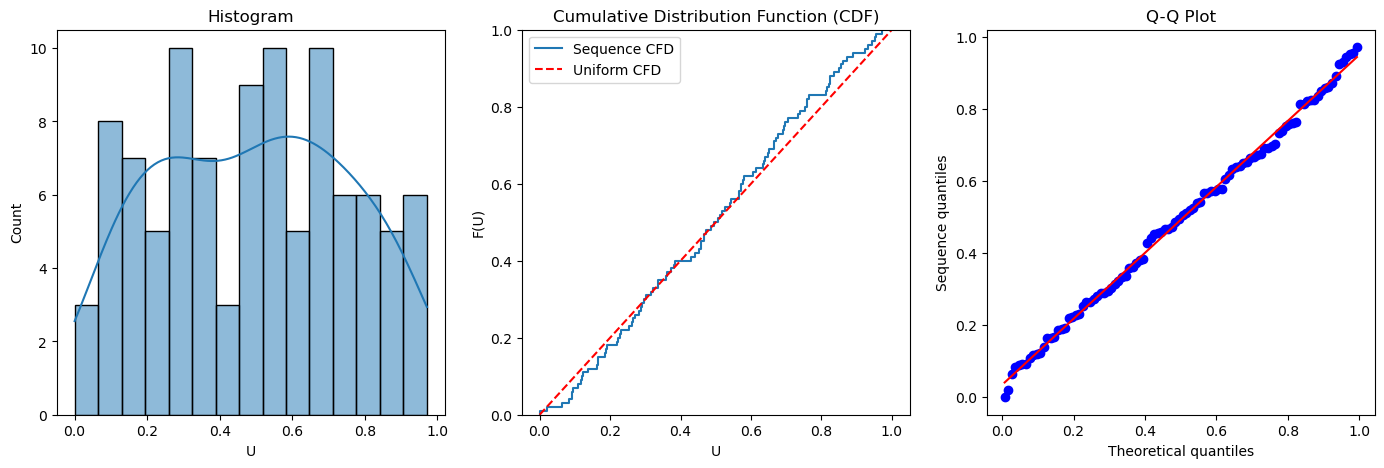

,Test,Test Statistic,P-value,null hypothesis,Remarks
0,kolmogorov-smirnov,0.066532,0.742376,accepted,The sequence is uniformly distributed
1,chi-square,11.600000,0.638391,accepted,The sequence is uniformly distributed


In [113]:
fig, ax = plt.subplots(1,3, figsize=(17,5))

# histogram
sns.histplot(u, stat="count", kde=True, bins=15, ax=ax[0])
ax[0].set(xlabel="U", title="Histogram")

# cdf
x = np.linspace(0, 1)
sns.ecdfplot(x=u, ax=ax[1], label="Sequence CFD")
ax[1].plot(x, CFD(x), "r--", label="Uniform CFD")
ax[1].set(xlabel="U", ylabel="F(U)", title="Cumulative Distribution Function (CDF)")
ax[1].legend()

# q-q plot
stats.probplot(u, dist='uniform', plot=ax[2])
ax[2].set(ylabel="Sequence quantiles", title="Q-Q Plot")

# kolmogorov-smirnov
ks_statistic, ks_p_value = stats.kstest(u, cdf= "uniform")

# chi-square
observed_frequencies, _ = np.histogram(u, bins=15)
average_frequency = np.sum(observed_frequencies) / len(observed_frequencies)
expected_frequencies = np.repeat([average_frequency], repeats=len(observed_frequencies))
chi_statistic, chi_p_value = stats.chisquare(observed_frequencies, expected_frequencies)

# summary
summary = [
    ("kolmogorov-smirnov", ks_statistic , ks_p_value),
    ("chi-square", chi_statistic, chi_p_value)
    ]
df = pd.DataFrame(data=summary, columns=["Test", "Test Statistic", "P-value"])
df["null hypothesis"] = np.where(df['P-value'] >= alpha, "accepted", "rejected")
df["Remarks"] = np.where(df['P-value'] >= alpha, "The sequence is uniformly distributed", "The sequence is not uniformly distributed")

plt.show()
df

### Periodicity and Pattern Analysis
This investigation looks for patterns and trends in generator behavior. The investigation is carried in many directions, one by generating two independent sequences to **study the behavior of the generator in higher dimensions**. The other direction is generating single sequence to **study behavior generator in single dimension**.
- Cycle Length: *Check the length of the sequence before it start repeating.*
- Scatter Plot: *Generator discrepancy analysis*
- AutoCorrelation Test: *Check the dependance between realizations in the sequence*

> Generating two independent sequences is obtained by shifting the seed of the second sequence far away form the first sequence.

In [114]:
def cycle_length(seed: int, a: int = 48271, m: int = 2**31-1) -> int:
    '''
    Compute the cycle length of Linear Congruential Generator (LCG) through tracing the index of
    the second occurrence of the first realization of the random number

    Args:
        seed: generator seed
        a: Method param, preferably chosen large and prime
        m: Method param, preferably chosen very large and prime

    Returns:
        cycle_length: Cycle length
    '''

    # tracing variables
    cycle_length = 0

    z = seed
    while True:
        z_i = (a*z)%m
        u_i = z_i/m

        z = z_i
        
        if cycle_length == 0:
            u_0 = u_i
        elif u_i == u_0 and cycle_length != 0:
            return cycle_length

        cycle_length = cycle_length + 1

In [115]:
# generate two independent sequences
u_1 = LCG(1000, seed, a, m)
u_2 = LCG(1000, seed+2000, a, m)

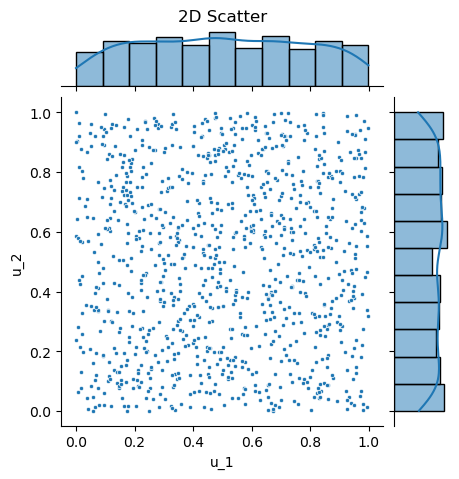

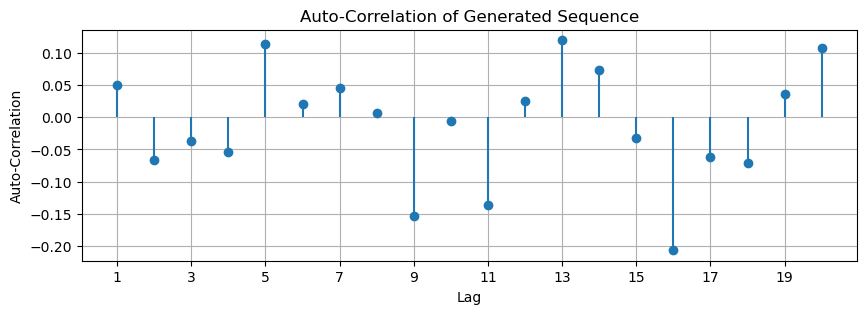

,Property,Quantity
0,cycle length,35696 realizations
1,strongest correlation,0.206334


In [116]:
# periodicity analysis
cl = cycle_length(seed, a, m)

# scatter
scatter = sns.jointplot(x=u_1, y=u_2, height=4.5, marker=".", marginal_kws={"kde": True})
scatter.ax_joint.set(xlabel="u_1", ylabel="u_2")
scatter.ax_marg_x.set(title="2D Scatter")

# autocorrelation
autocorrelation_function = [pd.Series(u).autocorr(lag=lag) for lag in range(1,21)]
fig, ax = plt.subplots(1,1, figsize=(10, 3))
ax.stem(range(1,21), autocorrelation_function, basefmt=" ")
ax.set(xlabel='Lag', ylabel='Auto-Correlation', title='Auto-Correlation of Generated Sequence', xticks=range(1,21,2)) 
ax.grid(True)

# summary
summary = [
    ("cycle length",            f"{cl} realizations"),
    ("strongest correlation",   np.nanmax(np.abs(autocorrelation_function)))
    ]

df = pd.DataFrame(data=summary, columns=["Property", "Quantity"])

plt.show()
df

We can see from the scatter plot that generated $(u_1, u_2)$ realizations do not look homogeneously distributed. In fact, one can observe that they form some sort of “clusters” and “holes”. It is a general property of uniformly distributed pseudo-random numbers.

### Convergence Analysis
In this section we will investigate how fast the random number generator converge to the desired distribution. This will be done by tracing the absolute error of the properties of the generated sequence as the sample size $N$ "i.e. the sequence length" increases. The properties that we will investigate are the following
- CFD Convergence Plot: Investigate convergence to the desired distribution.
- Parameters Error Plot: Compare the error between the generated sequence distribution parameters and the uniform distribution parameters. This will give information on the convergence of distribution parameters of the generated sequence.

#### cfd convergence calculations

In [123]:
# sequence lengths
Ns_cfd = np.linspace(5, 5000, num=200, dtype=int)

# points
n = 20                  
x = np.linspace(0, 1, n)

cfd_errors = np.zeros(len(Ns_cfd))
for i, N in enumerate(Ns_cfd):
    # sequence
    u_rng = LCG(N, seed)

    # rng cfd
    pdf_rng, _ = np.histogram(u_rng, bins=n)
    cumulative_sum = np.cumsum(pdf_rng)
    cdf_rng = cumulative_sum/cumulative_sum[-1]

    cfd_errors[i] = np.sum(abs(CFD(x) - cdf_rng))

#### kurtosis error

In [124]:
# sequence lengths
Ns_param = np.linspace(5, 10000, num=200, dtype=int)

# runs to average parameters over to reduce the wild fluctuations 
runs=30

param_errors = np.zeros((len(Ns_param), 4))
for i, N in enumerate(Ns_param):
    for run in range(runs):
        # sequence
        u_rng = LCG(N, seed=np.random.randint(1,100))

        # errors in parameters
        param_errors[i, 0] += abs(mean - np.mean(u_rng))
        param_errors[i, 1] += abs(var - np.var(u_rng))
        param_errors[i, 2] += abs(skew - stats.skew(u_rng))
        param_errors[i, 3] += abs(kurt - stats.kurtosis(u_rng))
    
    param_errors[i, :] = param_errors[i, :]/runs

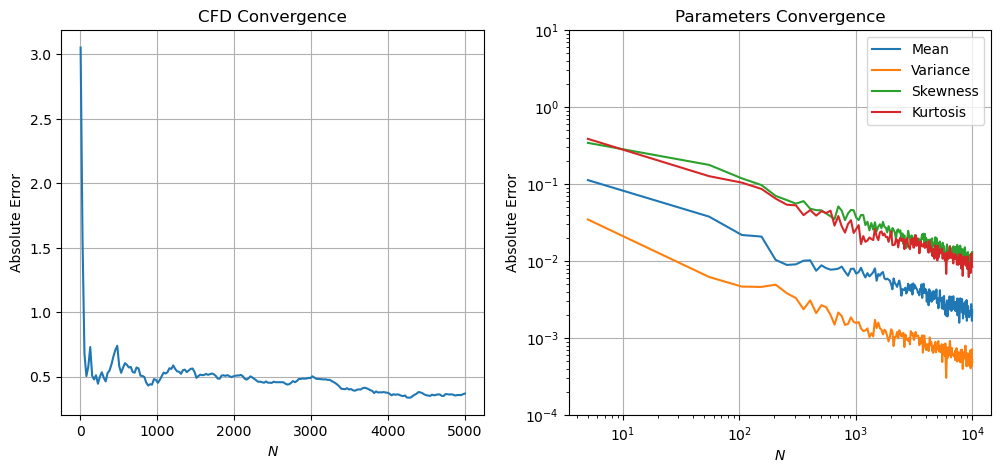

In [125]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))

# cdf error
ax[0].plot(Ns_cfd, cfd_errors, label="CFD Error")
ax[0].set(xlabel=r"$N$", ylabel="Absolute Error", title="CFD Convergence")
ax[0].grid(True)

# parameters errors
ax[1].plot(Ns_param, param_errors[:,0], label="Mean")
ax[1].plot(Ns_param, param_errors[:,1], label="Variance")
ax[1].plot(Ns_param, param_errors[:,2], label="Skewness")
ax[1].plot(Ns_param, param_errors[:,3], label="Kurtosis")
ax[1].set(xscale="log", yscale="log", ylim=[1e-4, 10], xlabel=r"$N$", ylabel="Absolute Error", title="Parameters Convergence")
ax[1].grid(True)
ax[1].legend()

plt.show()